In [ ]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-chronos[all]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit() # restart the runtime to refresh installed pkg

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import pandas as pd
import urllib.request
import json
import math

## Get data

In [ ]:
f = open('/content/stock_prices.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)
 
# Iterating through the json
# list
with open('data.json', 'w') as f:
    json.dump(data['data'], f)

data = pd.read_json('data.json')
data

,code,date,time,floor,type,basicPrice,ceilingPrice,floorPrice,open,high,low,close,average,adOpen,adHigh,adLow,adClose,adAverage,nmVolume,nmValue,ptVolume,ptValue,change,adChange,pctChange
0,VCB,2022-01-20,15:01:03,HOSE,STOCK,86.8,92.8,80.8,85.2,87.5,83.1,87.1,85.660,85.200,87.500,83.100,87.100,85.660,2794300,239372970000,0,0,0.3,0.3000,0.3456
1,VCB,2022-01-19,15:01:02,HOSE,STOCK,87.6,93.7,81.5,87.5,87.5,85.0,86.8,86.330,87.500,87.500,85.000,86.800,86.330,914800,78972420000,500000,41500000000,-0.8,-0.8000,-0.9132
2,VCB,2022-01-18,15:01:03,HOSE,STOCK,86.2,92.2,80.2,85.5,87.6,84.0,87.6,86.350,85.500,87.600,84.000,87.600,86.350,1696600,146506850000,39000,3412500000,1.4,1.4000,1.6241
3,VCB,2022-01-17,15:01:03,HOSE,STOCK,83.4,89.2,77.6,83.0,88.0,82.3,86.2,85.640,83.000,88.000,82.300,86.200,85.640,2628500,225104290000,40030,3476541000,2.8,2.8000,3.3573
4,VCB,2022-01-14,15:01:03,HOSE,STOCK,81.9,87.6,76.2,81.9,83.4,81.0,83.4,82.770,81.900,83.400,81.000,83.400,82.770,1522100,125980020000,30000,2307000000,1.5,1.5000,1.8315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254,VCB,2013-01-08,14:01:05,HOSE,STOCK,30.0,31.5,28.5,30.6,31.5,30.1,31.5,30.809,12.872,13.251,12.663,13.251,12.959,1035220,31894000000,0,0,1.5,0.6310,5.0000
2255,VCB,2013-01-07,14:01:04,HOSE,STOCK,29.2,30.6,27.8,28.0,30.0,28.0,30.0,29.373,11.779,12.620,11.779,12.620,12.357,1312740,38559000000,0,0,0.8,0.3365,2.7397
2256,VCB,2013-01-04,14:01:07,HOSE,STOCK,28.5,29.9,27.1,28.0,29.5,27.8,29.2,28.821,11.779,12.410,11.695,12.283,12.124,501540,14455000000,0,0,0.7,0.2945,2.4561
2257,VCB,2013-01-03,14:01:06,HOSE,STOCK,27.8,29.1,26.5,27.9,28.5,27.0,28.5,28.050,11.737,11.989,11.358,11.989,11.801,500650,14043000000,0,0,0.7,0.2945,2.5180


In [ ]:
data.sort_values(by="date", ignore_index=True, inplace=True)

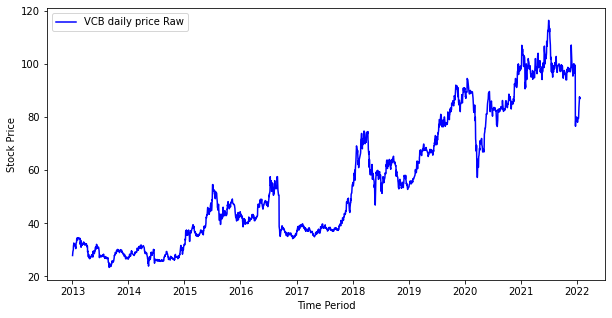

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.plot(data.date, data.close, color='blue', label='VCB daily price Raw')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Data Pre-processing

In [ ]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import MinMaxScaler

df = data[['date', 'close']]
df.rename(columns={"date": "ds", "close": "y"},inplace=True)
tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="ds", target_col="y", with_split=True, val_ratio=0.1,test_ratio=0.1)
minmax_scaler = MinMaxScaler()

# for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
#     tsdata.scale(minmax_scaler, fit=(tsdata is tsdata_train))\
#           .roll(lookback=50, horizon=1)

train_data = tsdata_train.to_pandas()
validation_data = tsdata_val.to_pandas()
test_data = tsdata_test.to_pandas()
print(train_data.shape[0])
print(validation_data.shape[0])

## ProphetForecaster

In [ ]:
!pip install prophet

In [ ]:
from bigdl.chronos.forecaster.prophet_forecaster import ProphetForecaster

/usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/__init__.py:36: UserWarning: Please install `tensorflow<2.0.0` to use MTNetForecaster.
  warnings.warn("Please install `tensorflow<2.0.0` to use MTNetForecaster.")
/usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/__init__.py:46: UserWarning: Please install `pmdarima` to use ARIMAForecaster.
  warnings.warn("Please install `pmdarima` to use ARIMAForecaster.")


In [ ]:
model = ProphetForecaster(changepoint_prior_scale=0.01, seasonality_prior_scale=5, holidays_prior_scale=5, seasonality_mode='multiplicative', changepoint_range=0.9)
val_mse = model.fit(data=train_data, validation_data=validation_data)["mse"]
print("Validation MSE: ", val_mse)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Validation MSE:  41.84789087421632


In [ ]:
# make prediction
y_pred = model.predict(ds_data=test_data[['ds']])

In [ ]:
from bigdl.orca.automl.metrics import Evaluator
print("RMSE is", Evaluator.evaluate("rmse", test_data[['y']].to_numpy(), y_pred[['yhat']].to_numpy(), multioutput='uniform_average'))
print("MAPE is", Evaluator.evaluate("mape", test_data[['y']].to_numpy(), y_pred[['yhat']].to_numpy(), multioutput='uniform_average'))

RMSE is 10.294791956346549
MAPE is 8.052517507611787


In [ ]:
# test_mse, test_smape = model.evaluate(data=test_data, metrics=["rmse","mape"])
# print("test RMSE: ", test_mse)
# print("test MAPE: ", test_smape)

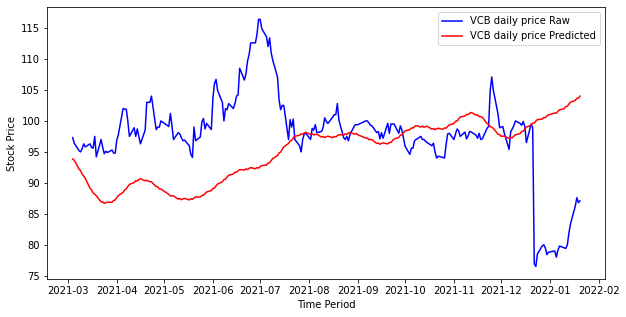

In [ ]:
# Plot predictions

plt.figure(figsize=(10,5))
plt.plot(tsdata_test.df.ds,test_data[['y']].values, color='blue', label="VCB daily price Raw")
plt.plot(tsdata_test.df.ds,y_pred[['yhat']].values, color='red', label="VCB daily price Predicted")
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()